In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sklearn.datasets

import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.set_default_dtype(torch.float32)

plt.rcParams['figure.dpi'] = 140
DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

### Generating the Two Moons / Circles Dataset

In [2]:
# Two Moons
def make_moon_training_data(sample_size=500):
    
    """Create two moon training dataset."""
    train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

    # Adjust data position slightly.
    train_examples[train_labels == 0] += [-0.1, 0.2]
    train_examples[train_labels == 1] += [0.1, -0.2]

    return train_examples, train_labels

def make_moon_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
    """Create a mesh grid in 2D space."""
    # testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xv, yv = np.meshgrid(x, y)
    return np.stack([xv.flatten(), yv.flatten()], axis=-1)

def make_moon_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
    return np.random.multivariate_normal(means, cov=np.diag(vars), size=sample_size)

# Two Circles
def make_circles_training_data(sample_size=500):
    
    """Create two circles training dataset."""
    train_examples, train_labels = sklearn.datasets.make_circles(
      n_samples=2 * sample_size, noise=0.1)

    # Adjust data position slightly.
    train_examples[train_labels == 0] += [-1.2, - 0.7]
    train_examples[train_labels == 1] += [1.15, - 0.7]

    return train_examples, train_labels

def make_circles_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
    """Create a mesh grid in 2D space."""
    # testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xv, yv = np.meshgrid(x, y)
    return np.stack([xv.flatten(), yv.flatten()], axis=-1)

def make_circles_ood_data(sample_size=500, means=(-0.3, 1.36), vars=(0.01, 0.01)):
    return np.random.multivariate_normal(means, cov=np.diag(vars), size=sample_size)

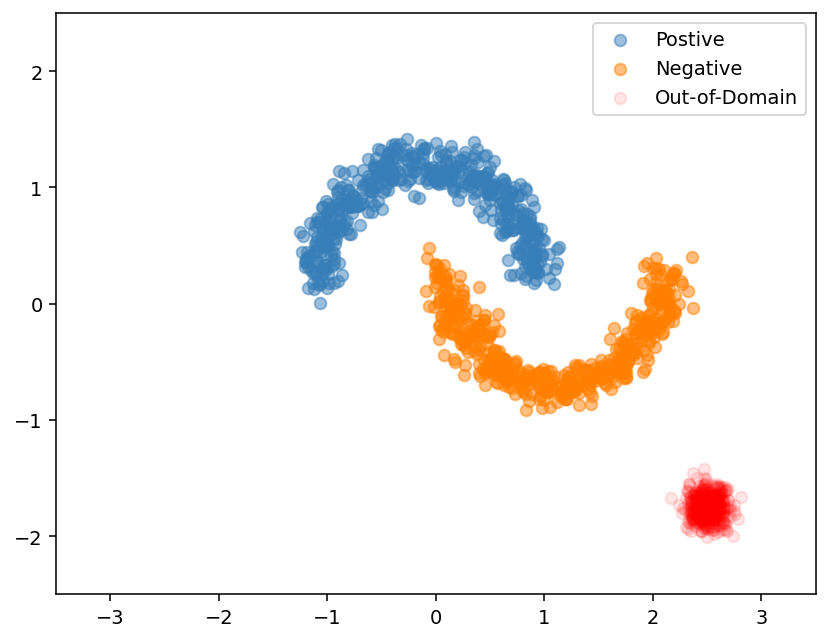

In [3]:
# Use false for Circles dataset
moon_dataset = True

# Load the Train, Test and OOD Dataset
if moon_dataset:
    train_examples, train_labels = make_moon_training_data(sample_size=500)
    test_examples = make_moon_testing_data()
    ood_examples = make_moon_ood_data(sample_size=500)
else:
    train_examples, train_labels = make_circles_training_data(sample_size=500)
    test_examples = make_circles_testing_data()
    ood_examples = make_circles_ood_data(sample_size=500)
    
# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Postive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

### Use GPU if available

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


### PyTorch Batched Dataset Loader

In [5]:
class TrainDataset(Dataset):
    def __init__(self, X, y, dtype_X = torch.FloatTensor, dtype_y = torch.LongTensor):
        
        self.train_examples = torch.from_numpy(X).type(dtype_X)
        self.train_labels = torch.from_numpy(y).type(dtype_y)

    def __len__(self):
        return len(self.train_examples)

    def __getitem__(self, idx):
        return self.train_examples[idx].to(device), self.train_labels[idx].to(device)

train_loader = DataLoader(TrainDataset(X=train_examples, y=train_labels), batch_size=128, shuffle=False, num_workers=0) 

In [6]:
# Sanity Check :)

for batch_num, (datas) in enumerate(train_loader):
    X, y = datas
    print(X.shape, y.shape, X.dtype, y.dtype)
    
    break

torch.Size([128, 2]) torch.Size([128]) torch.float32 torch.int64


### Model

In [7]:
# DNN Model
class DNN(nn.Module):
    def __init__(self, num_classes=2, num_hidden=1024, num_output=2):
        super().__init__()
        
        # Encoder Architecture
        self.net = nn.Sequential(
            nn.Linear(num_classes, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_output),
        )
            
    def forward(self, x):        
        out = self.net(x)
        return out
    
# Dropout Model
class DNN_dropout(nn.Module):
    def __init__(self, num_classes=2, num_hidden=1024, num_output=2, dropout_rate=0.15):
        super().__init__()
        
        # Encoder Architecture
        self.net = nn.Sequential(
            nn.Linear(num_classes, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(num_hidden, num_output),
        )
            
    def forward(self, x):        
        out = self.net(x)
        return out

In [8]:
from torchsummary import summary

use_dropout = False

if use_dropout:
    model = DNN_dropout().to(device)
else:
    model = DNN().to(device)

summary(model, (1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]           3,072
              ReLU-2              [-1, 1, 1024]               0
            Linear-3              [-1, 1, 1024]       1,049,600
              ReLU-4              [-1, 1, 1024]               0
            Linear-5              [-1, 1, 1024]       1,049,600
              ReLU-6              [-1, 1, 1024]               0
            Linear-7              [-1, 1, 1024]       1,049,600
              ReLU-8              [-1, 1, 1024]               0
            Linear-9              [-1, 1, 1024]       1,049,600
             ReLU-10              [-1, 1, 1024]               0
           Linear-11              [-1, 1, 1024]       1,049,600
             ReLU-12              [-1, 1, 1024]               0
           Linear-13              [-1, 1, 1024]       1,049,600
             ReLU-14              [-1, 

### Training Pipeline

In [9]:
epochs = 10
optimizer = optim.AdamW(model.parameters(), lr = 1e-4)
criterion = nn.CrossEntropyLoss()

model.train()
avg_train_loss = []
for epoch in range(epochs):
    
    # Train Loop
    losses_train = []
    for X, y in train_loader:
        
        X = X.to(device)
        y = y.to(device)
        
        outputs = model(X)
        loss = criterion(outputs, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses_train.append(loss.detach().cpu().numpy())
        
    print(f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.3f}")
    avg_train_loss.append(np.average(losses_train))

Epoch: 1, Train Loss: 0.671
Epoch: 2, Train Loss: 0.502
Epoch: 3, Train Loss: 0.136
Epoch: 4, Train Loss: 0.047
Epoch: 5, Train Loss: 0.019
Epoch: 6, Train Loss: 0.014
Epoch: 7, Train Loss: 0.018
Epoch: 8, Train Loss: 0.016
Epoch: 9, Train Loss: 0.003
Epoch: 10, Train Loss: 0.001


In [ ]:
torch.save(model.state_dict(), "model.pth")

### Visualizing Uncertainty Surface

In [10]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
    """Visualizes the 2D uncertainty surface.

    For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).

    Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the 
      predictive surface.

    Returns:
    pcm: A matplotlib PathCollection object that contains the palette 
      information of the uncertainty plot.
    """
    # Normalize uncertainty for better visualization.
    test_uncertainty = test_uncertainty / np.max(test_uncertainty)

    # Set view limits.
    ax.set_ylim(DEFAULT_Y_RANGE)
    ax.set_xlim(DEFAULT_X_RANGE)

    # Plot normalized uncertainty surface.
    pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]), 
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic', 
      aspect='auto')

    # Plot training data.
    ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
    ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

    return pcm

### Inference on OOD Data

In [11]:
test_examples = test_examples.astype(np.float32)
test_examples = torch.from_numpy(test_examples).to(device)

In [12]:
softmax = nn.Softmax(dim=-1)
model.eval()

with torch.no_grad():
    model_logits = model(test_examples)
    model_probs = softmax(model_logits)[:, 0]
    model_uncertainty = model_probs * (1 - model_probs)

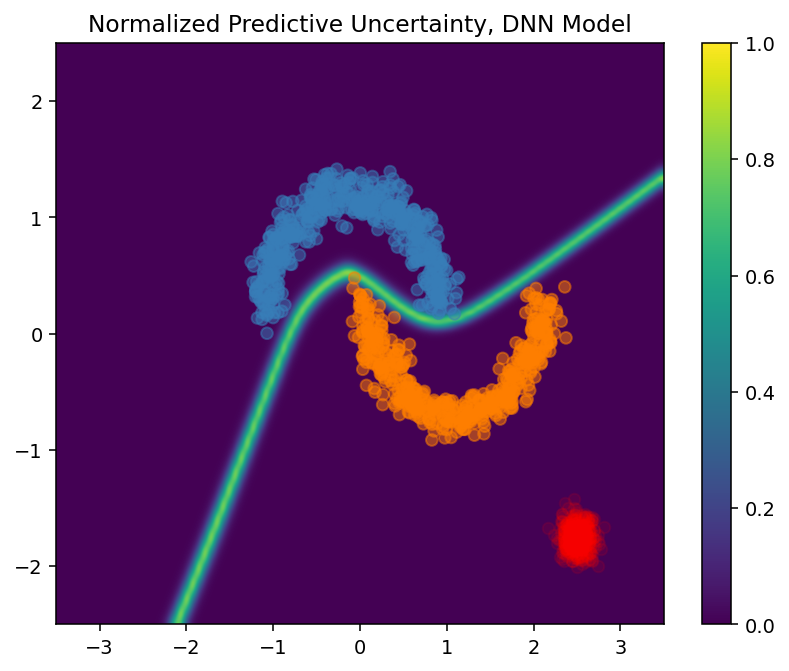

In [13]:
_, ax = plt.subplots(figsize=(7, 5.5))
pcm = plot_uncertainty_surface(model_uncertainty.cpu().numpy(), ax=ax)
plt.colorbar(pcm, ax=ax)
plt.title("Normalized Predictive Uncertainty, DNN Model")
plt.show()

### Deep Ensembles & MC Dropout

In [15]:
def train(num_hidden, use_dropout=False):
        
    # Model
    if use_dropout:
        model = DNN_dropout(num_classes=2, num_hidden=num_hidden, num_output=2, dropout_rate=0.15).to(device)
    else:
        model = DNN(num_classes=2, num_hidden=num_hidden, num_output=2).to(device)
    
    # Training Configurations
    epochs = 10
    optimizer = optim.AdamW(model.parameters(), lr = 1e-3)
    criterion = nn.CrossEntropyLoss()
    
    # Training Loop
    model.train()
    avg_train_loss = []
    for epoch in range(epochs):

        # Train Loop
        losses_train = []
        for X, y in train_loader:

            X = X.to(device)
            y = y.to(device)

            outputs = model(X)
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses_train.append(loss.detach().cpu().numpy())

        print(f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.3f}")
        avg_train_loss.append(np.average(losses_train))
    
    print("-" * 80)
    # Leads to different network configurations
    if use_dropout:
        model.train()
    else:
        model.eval()
    
    softmax = nn.Softmax(dim=-1)
    
    # Inference
    with torch.no_grad():
        model_logits = model(test_examples)
        model_probs = softmax(model_logits)[:, 0]
        
    return model_probs

In [16]:
# For Deep Ensemble Model
def deep_ensemble(num_hidden):
    model_probs = train(num_hidden, use_dropout=False)
    return model_probs

hidden_layer = [128, 256, 512, 1024, 2048]
ensemble_probs = [deep_ensemble(num_hidden) for num_hidden in hidden_layer]
ensemble_probs = torch.stack(ensemble_probs)
ensemble_probs = torch.mean(torch.tensor(ensemble_probs), dim=0)
ensemble_uncertainty = ensemble_probs * (1 - ensemble_probs)

Epoch: 1, Train Loss: 0.683
Epoch: 2, Train Loss: 0.556
Epoch: 3, Train Loss: 0.178
Epoch: 4, Train Loss: 0.064
Epoch: 5, Train Loss: 0.032
Epoch: 6, Train Loss: 0.028
Epoch: 7, Train Loss: 0.035
Epoch: 8, Train Loss: 0.023
Epoch: 9, Train Loss: 0.009
Epoch: 10, Train Loss: 0.005
--------------------------------------------------------------------------------
Epoch: 1, Train Loss: 0.622
Epoch: 2, Train Loss: 0.152
Epoch: 3, Train Loss: 0.066
Epoch: 4, Train Loss: 0.025
Epoch: 5, Train Loss: 0.022
Epoch: 6, Train Loss: 0.011
Epoch: 7, Train Loss: 0.006
Epoch: 8, Train Loss: 0.003
Epoch: 9, Train Loss: 0.003
Epoch: 10, Train Loss: 0.001
--------------------------------------------------------------------------------
Epoch: 1, Train Loss: 0.451
Epoch: 2, Train Loss: 0.097
Epoch: 3, Train Loss: 0.019
Epoch: 4, Train Loss: 0.009
Epoch: 5, Train Loss: 0.006
Epoch: 6, Train Loss: 0.001
Epoch: 7, Train Loss: 0.001
Epoch: 8, Train Loss: 0.000
Epoch: 9, Train Loss: 0.000
Epoch: 10, Train Loss: 0

/tmp/ipykernel_13002/3340049019.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ensemble_probs = torch.mean(torch.tensor(ensemble_probs), dim=0)


In [17]:
# For MC Dropout Model
def mc_dropout(num_hidden=1024):
    model_probs = train(num_hidden, use_dropout=True)
    return model_probs

num_ensembles = 5
dropout_probs = [mc_dropout() for _ in range(num_ensembles)]
dropout_probs = torch.stack(dropout_probs)
dropout_probs = torch.mean(torch.tensor(dropout_probs), dim=0)
dropout_uncertainty = dropout_probs * (1 - dropout_probs)

Epoch: 1, Train Loss: 0.378
Epoch: 2, Train Loss: 0.055
Epoch: 3, Train Loss: 0.013
Epoch: 4, Train Loss: 0.003
Epoch: 5, Train Loss: 0.002
Epoch: 6, Train Loss: 0.000
Epoch: 7, Train Loss: 0.000
Epoch: 8, Train Loss: 0.008
Epoch: 9, Train Loss: 0.001
Epoch: 10, Train Loss: 0.000
--------------------------------------------------------------------------------
Epoch: 1, Train Loss: 0.423
Epoch: 2, Train Loss: 0.054
Epoch: 3, Train Loss: 0.020
Epoch: 4, Train Loss: 0.016
Epoch: 5, Train Loss: 0.004
Epoch: 6, Train Loss: 0.001
Epoch: 7, Train Loss: 0.000
Epoch: 8, Train Loss: 0.000
Epoch: 9, Train Loss: 0.006
Epoch: 10, Train Loss: 0.003
--------------------------------------------------------------------------------
Epoch: 1, Train Loss: 0.426
Epoch: 2, Train Loss: 0.070
Epoch: 3, Train Loss: 0.031
Epoch: 4, Train Loss: 0.016
Epoch: 5, Train Loss: 0.007
Epoch: 6, Train Loss: 0.001
Epoch: 7, Train Loss: 0.000
Epoch: 8, Train Loss: 0.000
Epoch: 9, Train Loss: 0.000
Epoch: 10, Train Loss: 0

/tmp/ipykernel_13002/1925125493.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dropout_probs = torch.mean(torch.tensor(dropout_probs), dim=0)


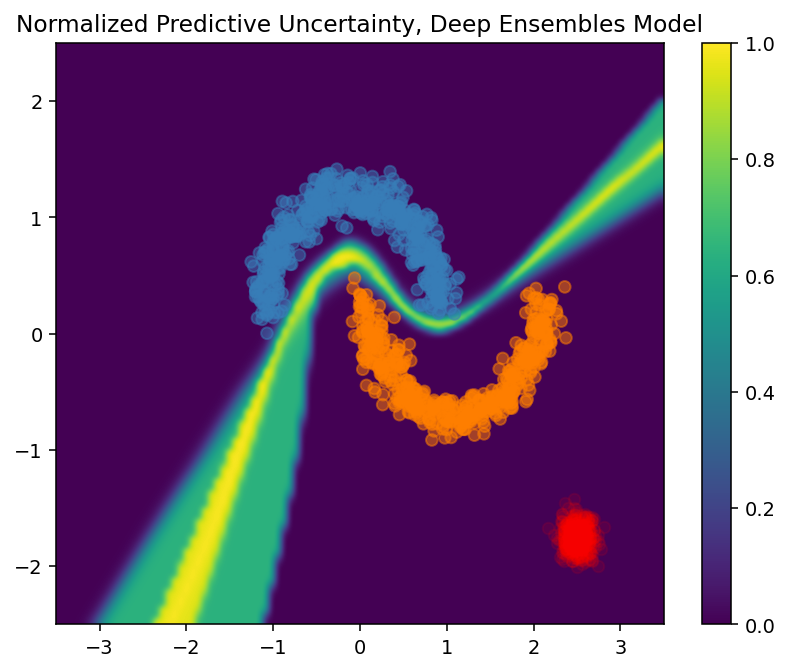

In [18]:
_, ax = plt.subplots(figsize=(7, 5.5))
pcm = plot_uncertainty_surface(ensemble_uncertainty.cpu().numpy(), ax=ax)
plt.colorbar(pcm, ax=ax)
plt.title("Normalized Predictive Uncertainty, Deep Ensembles Model")
plt.show()

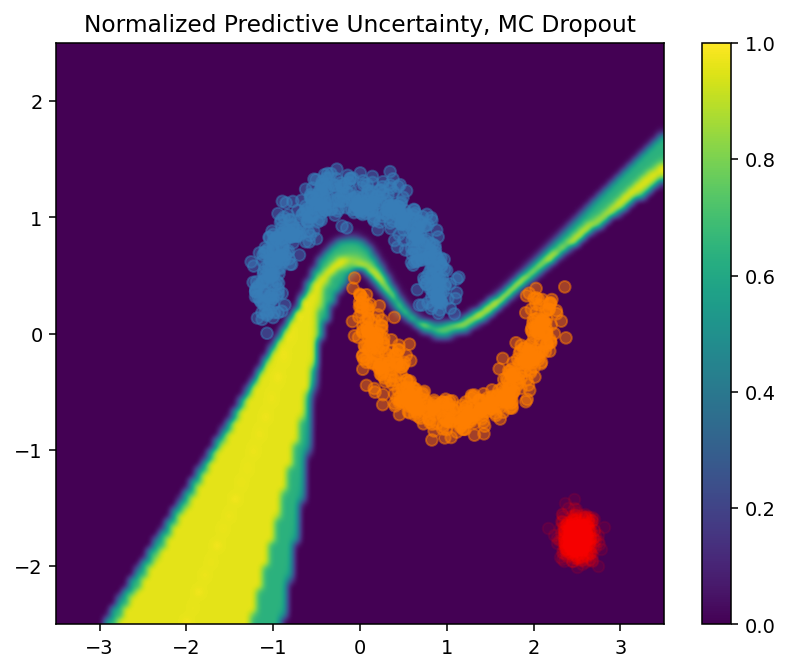

In [19]:
_, ax = plt.subplots(figsize=(7, 5.5))
pcm = plot_uncertainty_surface(dropout_uncertainty.cpu().numpy(), ax=ax)
plt.colorbar(pcm, ax=ax)
plt.title("Normalized Predictive Uncertainty, MC Dropout")
plt.show()